# Imports / Config

In [1]:
from datetime import datetime
from operator import itemgetter
import os
import pprint
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage as agglomerative_cluster
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

import configs
from clustering import gen_keywords
from content_corpus import ContentCorpus
from utils import clean, gen_clusters, lemmatize, simple_split, vectorize

pp = pprint.PrettyPrinter()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 16.9 µs


In [3]:
%%time
recent_content_corpus.load_recent_content(df=pd.read_csv('recent_content_corpus.csv', index_col=0),
                                          days_of_recent_content=2)
recent_content_corpus.df['meta_keywords'] = recent_content_corpus.df['meta_keywords'].apply(lambda x: x if type(x)== type('this') else '')
# recent_content_corpus.load_recent_content(days_of_recent_content=2)

CPU times: user 1.68 s, sys: 315 ms, total: 2 s
Wall time: 2.01 s


In [4]:
recent_content_corpus.df.to_csv('recent_content_corpus.csv')

In [5]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 28 s, sys: 984 ms, total: 28.9 s
Wall time: 29.1 s


In [6]:
%%time
recent_content_corpus.classify_content()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 svm classifier performance
 accuracy:   0.874
 classification report: 
                                precision    recall  f1-score   support

          Entertainment & Arts       0.88      1.00      0.94        69
            Finance & Business       0.89      0.91      0.90       125
                Gear & Gadgets       0.00      0.00      0.00         6
            Lifestyle & Health       0.67      0.46      0.55        26
  Politics, Policy & Economics       0.95      0.94      0.94        81
Technology, Science & Medicine       0.77      0.87      0.82        87
                 Travel & Food       1.00      0.36      0.53        14
                   U.S. Sports       1.00      1.00      1.00        20
                  World Sports       1.00      1.00      1.00        15

                   avg / total       0.86      0.87      0.86       443

 confusion matrix: 
[[ 69   0   0   0   0   0   0   0   0]
 [  0 114   0   0   2   9   0   0   0]
 [  1   0   0   1   0   4   0   0 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))



 svm classifier performance
 accuracy:   0.933
 classification report: 
                      precision    recall  f1-score   support

          Asia & ANZ       0.90      0.97      0.93       102
              Europe       0.90      0.88      0.89        51
       Latin America       0.00      0.00      0.00         1
Middle East & Africa       1.00      0.85      0.92        34
       U.S. & Canada       0.96      0.96      0.96       112

         avg / total       0.93      0.93      0.93       300

 confusion matrix: 
[[ 99   1   0   0   2]
 [  4  45   0   0   2]
 [  1   0   0   0   0]
 [  3   2   0  29   0]
 [  3   2   0   0 107]]
CPU times: user 4.54 s, sys: 108 ms, total: 4.65 s
Wall time: 3.01 s


# Story Clustering

## Cluster formation

In [7]:
topic = (
    'Politics, Policy & Economics'
#     'Finance & Business'
#     'Technology, Science & Medicine'
#     'U.S. Sports'
#     'Entertainment & Arts'
)
region = (
    'U.S. & Canada'
#     'Latin America'
#     'Europe'
#     'Middle East & Africa'
#     'Asia & ANZ'
)
MIN_WORDS = 100
filt = (
    (recent_content_corpus.df['topic_classification_predicted'] == topic)
    & (recent_content_corpus.df['topic_classification_probability'] > 0.5)
    & (recent_content_corpus.df['region_classification_predicted'] == region)
    & (recent_content_corpus.df['region_classification_probability'] > 0.5)
    & (recent_content_corpus.df['text_word_count'] >= MIN_WORDS)
)
df_subset = recent_content_corpus.df[filt].reset_index().drop(['index'], axis=1)
n_articles = len(df_subset)
print(n_articles)

6335


In [8]:
df_subset = df_subset.sample(min(n_articles, 2000)).reset_index()
n_articles = len(df_subset)

In [9]:
%%time
WORDS_TO_CONSIDER = 100
docs = list(df_subset['text'].apply(clean).apply(lambda x: ' '.join(x.split(' ')[:WORDS_TO_CONSIDER])))

CPU times: user 185 ms, sys: 2.79 ms, total: 187 ms
Wall time: 187 ms


In [10]:
%%time
# replace w/ recent_content_corpus_objcect
doc_vectors, doc_idx_2_token = vectorize(docs, tfidf=True)
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}
doc_vectors

CPU times: user 192 ms, sys: 4.64 ms, total: 196 ms
Wall time: 195 ms


In [11]:
%%time
docs_ac_result = agglomerative_cluster(
    doc_vectors.toarray(),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)

CPU times: user 18.4 s, sys: 159 ms, total: 18.6 s
Wall time: 18.7 s


In [194]:
docs_ac_result_dec = docs_ac_result[::-1]

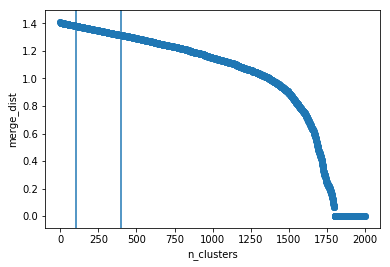

In [195]:
x_max = n_articles//2
plt.scatter(np.arange(n_articles-1), docs_ac_result_dec[:, 2])
plt.axvline(n_articles//20)
plt.axvline(n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
# plt.xlim(0, x_max)
# plt.ylim(min(docs_ac_result_dec[:x_max, 2]), max(docs_ac_result_dec[:x_max, 2]))
plt.show()
plt.close()

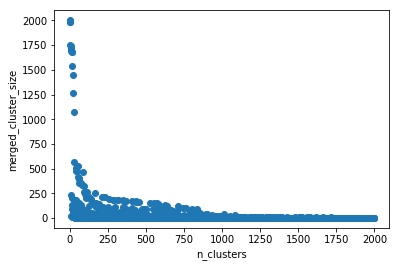

In [196]:
plt.scatter(np.arange(n_articles-1), docs_ac_result_dec[:, 3])
plt.xlabel('n_clusters')
plt.ylabel('merged_cluster_size')
plt.show()
plt.close()

## Keyword generation via token vector clustering (TVC)

In [13]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), stop_words='english',
    min_df=5, max_df = 0.25, binary=True
)
doc_vectors = count_vectorizer.fit_transform(docs)
doc_idx_2_token = count_vectorizer.get_feature_names()
doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}
token_vectors = doc_vectors.toarray().T

In [15]:
keywords = gen_keywords(token_vectors, doc_idx_2_token)
keywords

['border',
 'attorney general',
 'steve king',
 'fbi',
 'canadian',
 'turkey',
 'kirsten gillibrand',
 'judge',
 'clemson',
 'security administration',
 'pentagon said',
 'bozo taken',
 'poll',
 'hernia',
 'correctional institution',
 'enrique',
 'chris christie',
 'predecessors',
 'captured global',
 'maduro',
 'beto',
 'management budget',
 '50 series',
 'hirono',
 'study']

## Doc vector clustering - n selection via keyword recall & precision (KRP)

In [16]:
F1_EARLY_STOPPING_THRESHOLD = 0.98

In [17]:
n_clusters = []
keywords_recalls = {}
avg_recalls = []
keywords_precisions = {}
avg_precisions = []

for n in tqdm_notebook(np.arange(1, n_articles, 5)):
    df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)
    
    keyword_cluster_supports = {}
    for keyword in keywords:
        idx = doc_token_2_idx[keyword]
        df_subset['includes_keyword'] = (doc_vectors[:, idx].toarray() > 0)

        cluster_supports = df_subset[df_subset.includes_keyword]['story_cluster_id'].value_counts()
        max_cluster = cluster_supports.index[0]
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)

        cluster_supports = {cluster:support 
                            for cluster, support 
                            in zip(cluster_supports.index, cluster_supports.values)}
        cluster_supports['max_cluster'] = max_cluster
        cluster_supports['max_support'] = max_support
        cluster_supports['total_support'] = total_support

        keyword_cluster_supports[keyword] = cluster_supports

    recalls = []
    precisions = []
    for keyword in keywords:
        cluster_supports = keyword_cluster_supports[keyword]
        max_cluster = cluster_supports['max_cluster']
        max_support = cluster_supports['max_support']
        total_support = cluster_supports['total_support']

        recall = max_support / total_support
        
        if keyword in keywords_recalls:
            keywords_recalls[keyword].append(recall)
        else:
            keywords_recalls[keyword] = [recall]
        
        recalls.append(recall)

        max_cluster_other_kw_articles = np.sum(
            [other_cluster_supports[max_cluster] 
            for other_keyword, other_cluster_supports 
            in keyword_cluster_supports.items()
            if ((other_keyword != keyword) and (max_cluster in other_cluster_supports))]
        )
        precision = max_support / (max_support + max_cluster_other_kw_articles)
        if keyword in keywords_precisions:
            keywords_precisions[keyword].append(precision)
        else:
            keywords_precisions[keyword] = [precision]
        precisions.append(precision)
        
    n_clusters.append(n)
    avg_recalls.append(np.mean(recalls))
    avg_precisions.append(np.mean(precisions))
    

In [18]:
n_clusters = np.array(n_clusters)
avg_recalls = np.array(avg_recalls)
avg_precisions = np.array(avg_precisions)

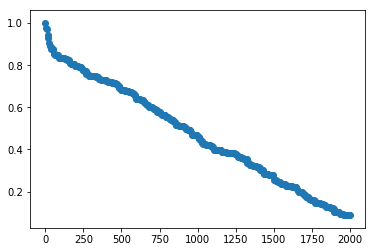

In [19]:
plt.scatter(n_clusters, avg_recalls)
plt.show()

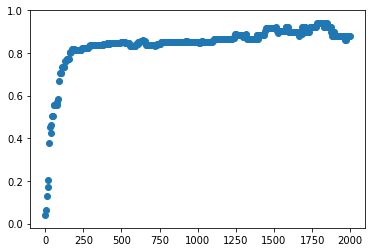

In [20]:
plt.scatter(n_clusters, avg_precisions)
plt.show()

In [21]:
avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)

In [22]:
max_f1 = np.max(avg_f1s)
close_enough_args = np.where(avg_f1s >= F1_EARLY_STOPPING_THRESHOLD * max_f1)

optimal_n_clusters = n_clusters[np.min(close_enough_args)]
optimal_n_clusters

141

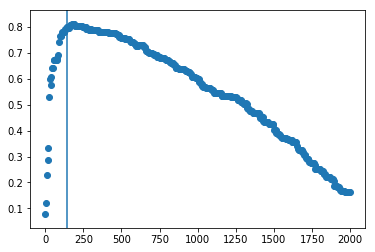

In [23]:
plt.scatter(n_clusters, avg_f1s)
plt.axvline(optimal_n_clusters)
plt.show()

In [24]:
df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, optimal_n_clusters)

In [25]:
story_cluster_id_counts = df_subset['story_cluster_id'].value_counts()

In [26]:
story_cluster_id_counts

3830    250
3853    159
3852    155
3698    117
3668     64
3804     61
3857     53
3820     45
3839     43
3810     39
3838     38
3826     38
3850     38
3730     36
3805     34
3774     27
3705     27
3752     26
3687     22
3656     22
3818     21
3841     20
3843     20
3749     18
3846     17
3851     17
3539     16
3591     16
3737     16
3495     14
       ... 
2196      2
2795      2
2931      2
2193      2
3273      2
2195      2
3265      2
3744      2
3433      2
3521      2
2188      2
3593      2
3661      2
3669      2
3700      2
3725      2
3734      2
3735      2
2198      2
3746      2
3754      2
2329      2
90        1
1996      1
547       1
1036      1
1290      1
1497      1
1656      1
31        1
Name: story_cluster_id, Length: 141, dtype: int64

In [27]:
iterations = 0 
for idx, ct in zip(story_cluster_id_counts.index, story_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = df_subset[
            df_subset['story_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




250 articles in cluster 3830
HEADLINE: Graham Presses Barr To Tell Congress If Trump Was Subject Of Counterintel Probe
HEADLINE: William Barr says in prepared testimony that Mueller should be allowed to ‘complete his work’ on the Russia probe
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: William Barr confirmation hearing: Trump's attorney general nominee still has a lot to answer for
HEADLINE: Trump’s attorney general pick reveals new details of meeting with him about Mueller investigation
HEADLINE: Trump Attorney General nominee won’t go after legal marijuana businesses and urges Congress to act
HEADLINE: Conspiracy Theorist Jerome Corsi Says Mueller Subpoenaed His Stepson to Testify in Russia Probe
HEADLINE: What Attorney General nominee William Barr promised Congress about Mueller
HEADLINE: Trump's AG Nominee Barr Pledges to Protect Mueller's Russia Probe
HEADLINE: Attorney General Appointee William Barr Defends Long Prison Sentenc

## Substory Clustering

In [1549]:
story_filt = (df_subset['story_cluster_id'] == story_cluster_id_counts.index[0])
story_indices = np.where(story_filt)[0]
story_subset = df_subset[story_filt].reset_index().drop(['index'], axis=1)

In [1550]:
%%time
story_titles = list(story_subset['title'].apply(clean))

CPU times: user 975 µs, sys: 37 µs, total: 1.01 ms
Wall time: 1 ms


In [1551]:
# prune outliers
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 1), stop_words='english',
    min_df=1, max_df = 1.0
)
story_title_vectors = tfidf_vectorizer.fit_transform(story_titles)
average_title = np.average(story_title_vectors.toarray(), axis=0).reshape(1, -1)
average_title_sims = cosine_similarity(story_title_vectors.toarray(), average_title).reshape(-1)

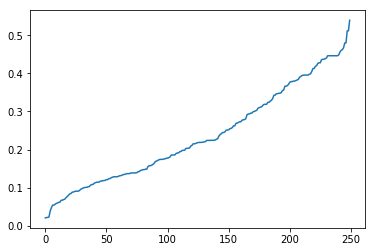

In [1552]:
plt.plot(sorted(average_title_sims))
plt.show()

In [1553]:
story_subset = story_subset[average_title_sims >= 0.1].reset_index().drop(['index'], axis=1)
story_n_articles = len(story_subset)

In [1554]:
story_docs = list(story_subset['title'].apply(clean))

In [1555]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), stop_words='english',
    min_df=2, max_df = 1.0
)
story_doc_vectors = tfidf_vectorizer.fit_transform(story_docs)
story_doc_idx_2_token = tfidf_vectorizer.get_feature_names()
story_doc_token_2_idx = {token:idx for idx, token in enumerate(story_doc_idx_2_token)}
token_vectors = story_doc_vectors.toarray().T

In [1556]:
%%time
substory_ac_result = agglomerative_cluster(
    story_doc_vectors.toarray(),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)
substory_ac_result_dec = substory_ac_result[::-1] # easier to work with

CPU times: user 13.7 ms, sys: 1.81 ms, total: 15.5 ms
Wall time: 19.1 ms


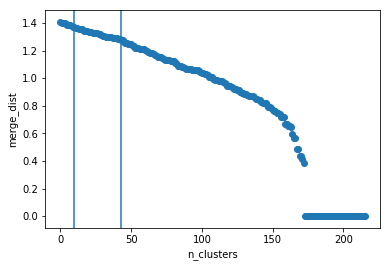

In [1557]:
x_max = story_n_articles//2
plt.scatter(np.arange(story_n_articles-1), substory_ac_result_dec[:, 2])
plt.axvline(story_n_articles//20)
plt.axvline(story_n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
# plt.xlim(0, x_max)
# plt.ylim(min(substory_ac_result_dec[:x_max, 2]), max(substory_ac_result_dec[:x_max, 2]))
plt.show()
plt.close()

In [1558]:
rlng_n = 10
rlng_avg_dists = [np.mean(substory_ac_result_dec[idx:idx+rlng_n, 2]) for idx in np.arange(story_n_articles-rlng_n)]

In [1559]:
dists_slope = [rlng_avg_dists[idx] - rlng_avg_dists[idx+1] for idx in np.arange(len(rlng_avg_dists)-1)]

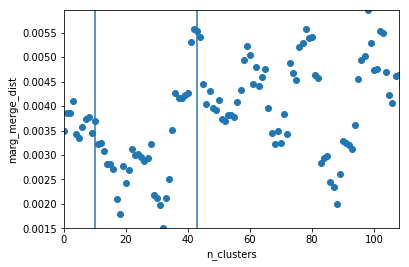

In [1560]:
plt.scatter(np.arange(len(dists_slope)), dists_slope)
plt.axvline(story_n_articles//20)
plt.axvline(story_n_articles//5)
plt.xlabel('n_clusters')
plt.ylabel('marg_merge_dist')
plt.xlim(0, x_max)
plt.ylim(min(dists_slope[:x_max]), max(dists_slope[:x_max]))
plt.show()
plt.close()

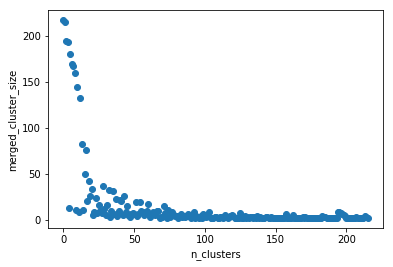

In [1561]:
plt.scatter(np.arange(story_n_articles-1), substory_ac_result_dec[:, 3])
plt.xlabel('n_clusters')
plt.ylabel('merged_cluster_size')
plt.show()
plt.close()

In [1562]:
n_clusters = []
n_gt_5 = []
for n in range(1, story_n_articles-1, 1):
    story_subset['substory_cluster_id'] = gen_clusters(substory_ac_result, n)
    
    n_clusters.append(n)
    n_gt_5.append(np.sum(story_subset['substory_cluster_id'].value_counts().values > 5))

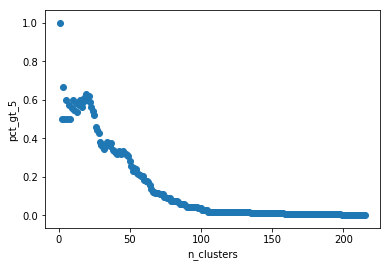

In [1563]:
plt.scatter(n_clusters, np.array(n_gt_5)/np.array(n_clusters))
plt.xlabel('n_clusters')
plt.ylabel('pct_gt_5')
plt.show()
plt.close()

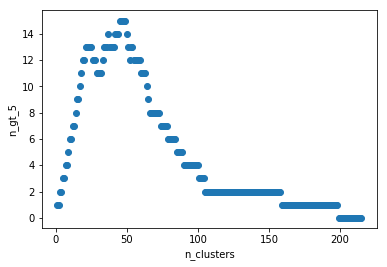

In [1564]:
plt.scatter(n_clusters, n_gt_5)
plt.xlabel('n_clusters')
plt.ylabel('n_gt_5')
plt.show()
plt.close()

In [1565]:
# optimal_n_clusters = story_n_articles//50 + np.argmin(dists_slope[story_n_articles//50:story_n_articles//5])
# optimal_n_clusters = story_n_articles//10
optimal_n_clusters = 10 # just before top cluster runs away
story_subset['substory_cluster_id'] = gen_clusters(substory_ac_result, optimal_n_clusters)

In [1566]:
substory_cluster_id_counts = story_subset['substory_cluster_id'].value_counts()
substory_cluster_id_counts

422    144
415     20
407     16
423     11
421      8
408      7
375      5
254      2
259      2
258      2
Name: substory_cluster_id, dtype: int64

In [1567]:
iterations = 0 
for idx, ct in zip(substory_cluster_id_counts.index, substory_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = story_subset[
            story_subset['substory_cluster_id'] == idx
        ]
        articles = len(cluster_content)
        for num, row in cluster_content[:min(100, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print(('TS:' + row['crawled_timestamp']))
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




144 articles in cluster 422
HEADLINE: Graham Presses Barr To Tell Congress If Trump Was Subject Of Counterintel Probe
HEADLINE: William Barr says in prepared testimony that Mueller should be allowed to ‘complete his work’ on the Russia probe
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: William Barr confirmation hearing: Trump's attorney general nominee still has a lot to answer for
HEADLINE: Trump’s attorney general pick reveals new details of meeting with him about Mueller investigation
HEADLINE: Trump Attorney General nominee won’t go after legal marijuana businesses and urges Congress to act
HEADLINE: What Attorney General nominee William Barr promised Congress about Mueller
HEADLINE: Trump's AG Nominee Barr Pledges to Protect Mueller's Russia Probe
HEADLINE: Attorney General Appointee William Barr Defends Long Prison Sentences, But Says He’s Open to Reforms
HEADLINE: The Latest: Barr doubts Mueller would engage in ‘witch hunt’
HE

In [1568]:
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2), min_df=2, max_df=0.25, 
    binary=True, stop_words='english'
)
story_doc_vectors = count_vectorizer.fit_transform(story_docs)
story_doc_idx_2_token = count_vectorizer.get_feature_names()
story_doc_token_2_idx = {token:idx for idx, token in enumerate(story_doc_idx_2_token)}
token_vectors = story_doc_vectors.toarray().T

In [1569]:
del gen_keywords

In [1582]:
def gen_keywords(token_vectors, idx_2_token):
    """
    Given a set of token x doc vectors, generates keywords for the corpus by
        agglomeratively clustering them and returning the tokens whose vectors
        are closest to the average of their cluster.

    Keyword arguments:
    token vectors - the token x doc vectors to be clustered (numpy array)
    idx_2_token - human-readable string representations of tokens (list)

    Returns:
    list of strings - keywords
    """
    ac_result = agglomerative_cluster(
        token_vectors,
        method='average',
        metric='cosine',
        optimal_ordering=False
    )

    token_clusters = gen_clusters(ac_result, 25)

    candidate_keywords = []
    for cluster_id in np.unique(token_clusters):
        filt = (token_clusters == cluster_id)

        tokens = np.array(idx_2_token)[filt]
        cluster_token_vectors = token_vectors[filt]

        mean_token_vector = np.mean(cluster_token_vectors, axis=0).reshape(1, -1)
        most_representative_idx = np.argmax(cosine_similarity(cluster_token_vectors, mean_token_vector))
        most_representative_token = tokens[most_representative_idx]

        candidate_keywords.append({
            'keyword': most_representative_token,
            'n_peer_words': len(tokens),
        })

    candidate_keywords = sorted(candidate_keywords, key=lambda x: x['n_peer_words'], reverse=True)
    keywords = [candidate['keyword']
                for candidate
                in candidate_keywords
                if candidate['n_peer_words'] >= configs.MIN_TOKEN_CLUSTER_SIZE][:configs.MAX_KEYWORDS]

    return keywords

In [1571]:
keywords = gen_keywords(token_vectors, story_doc_idx_2_token)
keywords

['probe',
 'interference',
 'confirmation',
 'whitaker',
 'filing',
 'dems',
 'fundamental',
 'cause',
 'different']

In [1583]:
keywords = gen_keywords(token_vectors, story_doc_idx_2_token)
keywords

['interference',
 'finish',
 'confirmation hearing',
 'whitaker',
 'russia probe',
 'robert',
 'dems',
 'filing',
 'trump pick',
 'fundamental',
 'hunt',
 'abc',
 'conceive',
 'act',
 'judiciary write',
 'stepson',
 'cause',
 'different']

In [1584]:
n_clusters = []
keywords_recalls = {}
avg_recalls = []
keywords_precisions = {}
avg_precisions = []

for n in tqdm_notebook(np.arange(1, story_n_articles, 1)):
    story_subset['story_cluster_id'] = gen_clusters(substory_ac_result, n)
    
    keyword_cluster_supports = {}
    for keyword in keywords:
        idx = story_doc_token_2_idx[keyword]
        story_subset['includes_keyword'] = (story_doc_vectors[:, idx].toarray() > 0)

        cluster_supports = story_subset[story_subset.includes_keyword]['story_cluster_id'].value_counts()
        max_cluster = cluster_supports.index[0]
        max_support = cluster_supports.values[0]
        total_support = np.sum(cluster_supports.values)

        cluster_supports = {cluster:support 
                            for cluster, support 
                            in zip(cluster_supports.index, cluster_supports.values)}
        cluster_supports['max_cluster'] = max_cluster
        cluster_supports['max_support'] = max_support
        cluster_supports['total_support'] = total_support

        keyword_cluster_supports[keyword] = cluster_supports

    recalls = []
    precisions = []
    for keyword in keywords:
        cluster_supports = keyword_cluster_supports[keyword]
        max_cluster = cluster_supports['max_cluster']
        max_support = cluster_supports['max_support']
        total_support = cluster_supports['total_support']

        recall = max_support / total_support
        
        if keyword in keywords_recalls:
            keywords_recalls[keyword].append(recall)
        else:
            keywords_recalls[keyword] = [recall]
        
        recalls.append(recall)

        max_cluster_other_kw_articles = np.sum(
            [other_cluster_supports[max_cluster] 
            for other_keyword, other_cluster_supports 
            in keyword_cluster_supports.items()
            if ((other_keyword != keyword) and (max_cluster in other_cluster_supports))]
        )
        precision = max_support / (max_support + max_cluster_other_kw_articles)
        if keyword in keywords_precisions:
            keywords_precisions[keyword].append(precision)
        else:
            keywords_precisions[keyword] = [precision]
        precisions.append(precision)
        
    n_clusters.append(n)
    avg_recalls.append(np.mean(recalls))
    avg_precisions.append(np.mean(precisions))
    

In [1585]:
n_clusters = np.array(n_clusters)
avg_recalls = np.array(avg_recalls)
avg_precisions = np.array(avg_precisions)

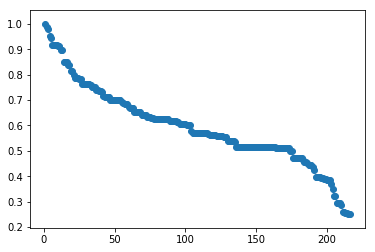

In [1586]:
plt.scatter(n_clusters, avg_recalls)
plt.show()

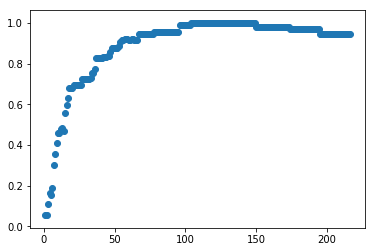

In [1587]:
plt.scatter(n_clusters, avg_precisions)
plt.show()

In [1588]:
avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)

In [1589]:
max_f1 = np.max(avg_f1s)
close_enough_args = np.where(avg_f1s >= F1_EARLY_STOPPING_THRESHOLD * max_f1)

optimal_n_clusters = n_clusters[np.min(close_enough_args)]
optimal_n_clusters

37

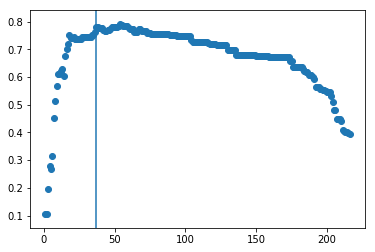

In [1590]:
plt.scatter(n_clusters, avg_f1s)
plt.axvline(optimal_n_clusters)
plt.show()

In [1591]:
story_subset['substory_cluster_id'] = gen_clusters(substory_ac_result, optimal_n_clusters)

In [1580]:
substory_cluster_id_counts = story_subset['substory_cluster_id'].value_counts()
substory_cluster_id_counts

422    144
415     20
407     16
423     11
421      8
408      7
375      5
254      2
259      2
258      2
Name: substory_cluster_id, dtype: int64

In [1592]:
substory_cluster_id_counts = story_subset['substory_cluster_id'].value_counts()
substory_cluster_id_counts

389    26
395    23
392    22
377    10
373    10
393    10
369     8
376     8
388     8
382     6
370     6
379     6
384     6
396     6
386     5
390     5
375     5
380     4
394     4
385     3
371     3
363     3
337     3
342     2
259     2
258     2
257     2
269     2
310     2
255     2
351     2
359     2
364     2
254     2
227     2
256     2
156     1
Name: substory_cluster_id, dtype: int64

In [1581]:
iterations = 0 
for idx, ct in zip(substory_cluster_id_counts.index, substory_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = story_subset[
            story_subset['substory_cluster_id'] == idx
        ]
        articles = len(cluster_content)
        for num, row in cluster_content[:min(100, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




144 articles in cluster 422
HEADLINE: Graham Presses Barr To Tell Congress If Trump Was Subject Of Counterintel Probe
HEADLINE: William Barr says in prepared testimony that Mueller should be allowed to ‘complete his work’ on the Russia probe
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: William Barr confirmation hearing: Trump's attorney general nominee still has a lot to answer for
HEADLINE: Trump’s attorney general pick reveals new details of meeting with him about Mueller investigation
HEADLINE: Trump Attorney General nominee won’t go after legal marijuana businesses and urges Congress to act
HEADLINE: What Attorney General nominee William Barr promised Congress about Mueller
HEADLINE: Trump's AG Nominee Barr Pledges to Protect Mueller's Russia Probe
HEADLINE: Attorney General Appointee William Barr Defends Long Prison Sentences, But Says He’s Open to Reforms
HEADLINE: The Latest: Barr doubts Mueller would engage in ‘witch hunt’
HE

In [1593]:
iterations = 0 
for idx, ct in zip(substory_cluster_id_counts.index, substory_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = story_subset[
            story_subset['substory_cluster_id'] == idx
        ]
        articles = len(cluster_content)
        for num, row in cluster_content[:min(100, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




26 articles in cluster 389
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: What Attorney General nominee William Barr promised Congress about Mueller
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: Attorney general nominee William Barr helped write the handbook on mass incarceration in the 1990s — but he says he realizes times have changed
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: Trump's attorney general nominee vows to shield Russia probe from politics
HEADLINE: Trump's attorney general pick Bill Barr to navigate through Democrats' questions about Mueller probe
HEADLINE: Judith Miller: 

# Loop

In [ ]:
topics = [
    'Politics, Policy & Economics',
    'Finance & Business',
    'Technology, Science & Medicine',
    'U.S. Sports',
    'Entertainment & Arts',
]
regions = [
    'U.S. & Canada',
    'Latin America',
    'Europe',
    'Middle East & Africa',
    'Asia & ANZ',
]

for topic in topics:
    for region in regions:
        print('\n')
        print(topic + ' - ' + region)
        MIN_WORDS = 100
        filt = (
            (recent_content_corpus.df['topic_classification_predicted'] == topic)
            & (recent_content_corpus.df['topic_classification_probability'] > 0.5)
            & (recent_content_corpus.df['region_classification_predicted'] == region)
            & (recent_content_corpus.df['region_classification_probability'] > 0.5)
            & (recent_content_corpus.df['text_word_count'] >= MIN_WORDS)
        )
        df_subset = recent_content_corpus.df[filt].reset_index().drop(['index'], axis=1)
        n_articles = len(df_subset)
        print(n_articles)
        
        if n_articles < 100:
            print('NOT ENOUGH ARTICLES')
            continue

        df_subset = df_subset.sample(min(n_articles, 2000)).reset_index()
        n_articles = len(df_subset)

        WORDS_TO_CONSIDER = 100
        docs = list(df_subset['text'].apply(clean).apply(lambda x: ' '.join(x.split(' ')[:WORDS_TO_CONSIDER])))

        # replace w/ recent_content_corpus_objcect
        doc_vectors, doc_idx_2_token = vectorize(docs, tfidf=True)
        doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

        docs_ac_result = agglomerative_cluster(
            doc_vectors.toarray(),
            method='average',
            metric='euclidean',
            optimal_ordering=False
        )

        count_vectorizer = CountVectorizer(
            ngram_range=(1, 2), stop_words='english',
            min_df=5, max_df = 0.25, binary=True
        )
        doc_vectors = count_vectorizer.fit_transform(docs)
        doc_idx_2_token = count_vectorizer.get_feature_names()
        doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

        token_vectors = doc_vectors.toarray().T
        tokens_ac_result = agglomerative_cluster(
            token_vectors,
            method='average',
            metric='cosine',
            optimal_ordering=False
        )
        
        token_clusters = gen_clusters(tokens_ac_result, 25)
        
        candidate_keywords = []
        for cluster_id in np.unique(token_clusters):
            filt = (token_clusters == cluster_id)
            tokens = np.array(doc_idx_2_token)[filt]
            cluster_token_vectors = token_vectors[filt]
            mean_token_vector = np.mean(cluster_token_vectors, axis=0).reshape(1, -1)
            most_representative_idx = np.argmax(cosine_similarity(cluster_token_vectors, mean_token_vector))
            most_representative_token = tokens[most_representative_idx]
            candidate_keywords.append({
                'token_cluster_id': cluster_id,
                'keyword': most_representative_token,
                'n_peer_words': len(tokens),
                'peer_words': tokens
            })

        candidate_keywords = sorted(candidate_keywords, key=lambda x: x['n_peer_words'], reverse=True)
        keywords = [candidate['keyword'] 
                    for candidate 
                    in candidate_keywords
                    if candidate['n_peer_words'] >= 10]

        if len(keywords) >= 10:
            n_clusters = []
            keywords_recalls = {}
            avg_recalls = []
            keywords_precisions = {}
            avg_precisions = []

            for n in tqdm_notebook(np.arange(1, n_articles, 5)):
                df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)

                keyword_cluster_supports = {}
                for keyword in keywords:
                    idx = doc_token_2_idx[keyword]
                    df_subset['includes_keyword'] = (doc_vectors[:, idx].toarray() > 0)

                    cluster_supports = df_subset[df_subset.includes_keyword]['story_cluster_id'].value_counts()
                    max_cluster = cluster_supports.index[0]
                    max_support = cluster_supports.values[0]
                    total_support = np.sum(cluster_supports.values)

                    cluster_supports = {cluster:support 
                                        for cluster, support 
                                        in zip(cluster_supports.index, cluster_supports.values)}
                    cluster_supports['max_cluster'] = max_cluster
                    cluster_supports['max_support'] = max_support
                    cluster_supports['total_support'] = total_support

                    keyword_cluster_supports[keyword] = cluster_supports

                recalls = []
                precisions = []
                for keyword in keywords:
                    cluster_supports = keyword_cluster_supports[keyword]
                    max_cluster = cluster_supports['max_cluster']
                    max_support = cluster_supports['max_support']
                    total_support = cluster_supports['total_support']

                    recall = max_support / total_support

                    if keyword in keywords_recalls:
                        keywords_recalls[keyword].append(recall)
                    else:
                        keywords_recalls[keyword] = [recall]

                    recalls.append(recall)

                    max_cluster_other_kw_articles = np.sum(
                        [other_cluster_supports[max_cluster] 
                        for other_keyword, other_cluster_supports 
                        in keyword_cluster_supports.items()
                        if ((other_keyword != keyword) and (max_cluster in other_cluster_supports))]
                    )
                    precision = max_support / (max_support + max_cluster_other_kw_articles)
                    if keyword in keywords_precisions:
                        keywords_precisions[keyword].append(precision)
                    else:
                        keywords_precisions[keyword] = [precision]
                    precisions.append(precision)

                n_clusters.append(n)
                avg_recalls.append(np.mean(recalls))
                avg_precisions.append(np.mean(precisions))

            fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
            for keyword in keywords:
                plt.plot(n_clusters, keywords_recalls[keyword], label=keyword) 
            plt.legend()
            plt.show()

            fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
            for keyword in keywords:
                plt.plot(n_clusters, keywords_precisions[keyword], label=keyword) 
            plt.legend()
            plt.show()

            n_clusters = np.array(n_clusters)
            avg_recalls = np.array(avg_recalls)
            avg_precisions = np.array(avg_precisions)

            plt.scatter(n_clusters, avg_recalls)
            plt.show()

            plt.scatter(n_clusters, avg_precisions)
            plt.show()

            avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)
            
            max_f1 = np.max(avg_f1s)
            close_enough_args = np.where(avg_f1s >= F1_EARLY_STOPPING_THRESHOLD * max_f1) # 0.99

            optimal_n_clusters = n_clusters[np.min(close_enough_args)]
            optimal_n_clusters

            plt.scatter(n_clusters, avg_f1s)
            plt.axvline(optimal_n_clusters)
            plt.show()

In [ ]:
topics = [
    'Politics, Policy & Economics',
    'Finance & Business',
    'Technology, Science & Medicine',
    'U.S. Sports',
    'Entertainment & Arts',
]
regions = [
    'U.S. & Canada',
    'Latin America',
    'Europe',
    'Middle East & Africa',
    'Asia & ANZ',
]

for topic in topics:
    for region in regions:
        print('\n')
        print(topic + ' - ' + region)
        MIN_WORDS = 100
        filt = (
            (recent_content_corpus.df['topic_classification_predicted'] == topic)
            & (recent_content_corpus.df['topic_classification_probability'] > 0.5)
            & (recent_content_corpus.df['region_classification_predicted'] == region)
            & (recent_content_corpus.df['region_classification_probability'] > 0.5)
            & (recent_content_corpus.df['text_word_count'] >= MIN_WORDS)
        )
        df_subset = recent_content_corpus.df[filt].reset_index().drop(['index'], axis=1)
        n_articles = len(df_subset)
        print(n_articles)
        
        if n_articles < 100:
            print('NOT ENOUGH ARTICLES')
            continue

        df_subset = df_subset.sample(min(n_articles, 2000)).reset_index()
        n_articles = len(df_subset)

        WORDS_TO_CONSIDER = 100
        docs = list(df_subset['text'].apply(clean).apply(lambda x: ' '.join(x.split(' ')[:WORDS_TO_CONSIDER])))

        # replace w/ recent_content_corpus_objcect
        doc_vectors, doc_idx_2_token = vectorize(docs, tfidf=True)
        doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

        docs_ac_result = agglomerative_cluster(
            doc_vectors.toarray(),
            method='average',
            metric='euclidean',
            optimal_ordering=False
        )

        count_vectorizer = CountVectorizer(
            ngram_range=(1, 2), stop_words='english',
            min_df=5, max_df = 0.25, binary=True
        )
        doc_vectors = count_vectorizer.fit_transform(docs)
        doc_idx_2_token = count_vectorizer.get_feature_names()
        doc_token_2_idx = {token:idx for idx, token in enumerate(doc_idx_2_token)}

        token_vectors = doc_vectors.toarray().T
        tokens_ac_result = agglomerative_cluster(
            token_vectors,
            method='average',
            metric='cosine',
            optimal_ordering=False
        )
        
        token_clusters = gen_clusters(tokens_ac_result, 25)
        
        candidate_keywords = []
        for cluster_id in np.unique(token_clusters):
            filt = (token_clusters == cluster_id)
            tokens = np.array(doc_idx_2_token)[filt]
            cluster_token_vectors = token_vectors[filt]
            mean_token_vector = np.mean(cluster_token_vectors, axis=0).reshape(1, -1)
            most_representative_idx = np.argmax(cosine_similarity(cluster_token_vectors, mean_token_vector))
            most_representative_token = tokens[most_representative_idx]
            candidate_keywords.append({
                'token_cluster_id': cluster_id,
                'keyword': most_representative_token,
                'n_peer_words': len(tokens),
                'peer_words': tokens
            })

        candidate_keywords = sorted(candidate_keywords, key=lambda x: x['n_peer_words'], reverse=True)
        keywords = [candidate['keyword'] 
                    for candidate 
                    in candidate_keywords
                    if candidate['n_peer_words'] >= 10]

        if len(keywords) >= 10:
            n_clusters = []
            keywords_recalls = {}
            avg_recalls = []
            keywords_precisions = {}
            avg_precisions = []

            for n in tqdm_notebook(np.arange(1, n_articles, 5)):
                df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n)

                keyword_cluster_supports = {}
                for keyword in keywords:
                    idx = doc_token_2_idx[keyword]
                    df_subset['includes_keyword'] = (doc_vectors[:, idx].toarray() > 0)

                    cluster_supports = df_subset[df_subset.includes_keyword]['story_cluster_id'].value_counts()
                    max_cluster = cluster_supports.index[0]
                    max_support = cluster_supports.values[0]
                    total_support = np.sum(cluster_supports.values)

                    cluster_supports = {cluster:support 
                                        for cluster, support 
                                        in zip(cluster_supports.index, cluster_supports.values)}
                    cluster_supports['max_cluster'] = max_cluster
                    cluster_supports['max_support'] = max_support
                    cluster_supports['total_support'] = total_support

                    keyword_cluster_supports[keyword] = cluster_supports

                recalls = []
                precisions = []
                for keyword in keywords:
                    cluster_supports = keyword_cluster_supports[keyword]
                    max_cluster = cluster_supports['max_cluster']
                    max_support = cluster_supports['max_support']
                    total_support = cluster_supports['total_support']

                    recall = max_support / total_support

                    if keyword in keywords_recalls:
                        keywords_recalls[keyword].append(recall)
                    else:
                        keywords_recalls[keyword] = [recall]

                    recalls.append(recall)

                    max_cluster_other_kw_articles = np.sum(
                        [other_cluster_supports[max_cluster] 
                        for other_keyword, other_cluster_supports 
                        in keyword_cluster_supports.items()
                        if ((other_keyword != keyword) and (max_cluster in other_cluster_supports))]
                    )
                    precision = max_support / (max_support + max_cluster_other_kw_articles)
                    if keyword in keywords_precisions:
                        keywords_precisions[keyword].append(precision)
                    else:
                        keywords_precisions[keyword] = [precision]
                    precisions.append(precision)

                n_clusters.append(n)
                avg_recalls.append(np.mean(recalls))
                avg_precisions.append(np.mean(precisions))

            fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
            for keyword in keywords:
                plt.plot(n_clusters, keywords_recalls[keyword], label=keyword) 
            plt.legend()
            plt.show()

            fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
            for keyword in keywords:
                plt.plot(n_clusters, keywords_precisions[keyword], label=keyword) 
            plt.legend()
            plt.show()

            n_clusters = np.array(n_clusters)
            avg_recalls = np.array(avg_recalls)
            avg_precisions = np.array(avg_precisions)

            plt.scatter(n_clusters, avg_recalls)
            plt.show()

            plt.scatter(n_clusters, avg_precisions)
            plt.show()

            avg_f1s = 2 * (avg_precisions * avg_recalls) / (avg_precisions + avg_recalls)
            
            max_f1 = np.max(avg_f1s)
            close_enough_args = np.where(avg_f1s >= F1_EARLY_STOPPING_THRESHOLD * max_f1) # 0.98

            optimal_n_clusters = n_clusters[np.min(close_enough_args)]
            optimal_n_clusters

            plt.scatter(n_clusters, avg_f1s)
            plt.axvline(optimal_n_clusters)
            plt.show()